<h1>Chapter 4 - Text Classification</h1>
<i>Classifying text with both representative and generative models</i>

<a href="https://www.amazon.com/Hands-Large-Language-Models-Understanding/dp/1098150961"><img src="https://img.shields.io/badge/Buy%20the%20Book!-grey?logo=amazon"></a>
<a href="https://www.oreilly.com/library/view/hands-on-large-language/9781098150952/"><img src="https://img.shields.io/badge/O'Reilly-white.svg?logo=data:image/svg%2bxml;base64,PHN2ZyB3aWR0aD0iMzQiIGhlaWdodD0iMjciIHZpZXdCb3g9IjAgMCAzNCAyNyIgZmlsbD0ibm9uZSIgeG1sbnM9Imh0dHA6Ly93d3cudzMub3JnLzIwMDAvc3ZnIj4KPGNpcmNsZSBjeD0iMTMiIGN5PSIxNCIgcj0iMTEiIHN0cm9rZT0iI0Q0MDEwMSIgc3Ryb2tlLXdpZHRoPSI0Ii8+CjxjaXJjbGUgY3g9IjMwLjUiIGN5PSIzLjUiIHI9IjMuNSIgZmlsbD0iI0Q0MDEwMSIvPgo8L3N2Zz4K"></a>
<a href="https://github.com/HandsOnLLM/Hands-On-Large-Language-Models"><img src="https://img.shields.io/badge/GitHub%20Repository-black?logo=github"></a>
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/HandsOnLLM/Hands-On-Large-Language-Models/blob/main/chapter04/Chapter%204%20-%20Text%20Classification.ipynb)

---

This notebook is for Chapter 4 of the [Hands-On Large Language Models](https://www.amazon.com/Hands-Large-Language-Models-Understanding/dp/1098150961) book by [Jay Alammar](https://www.linkedin.com/in/jalammar) and [Maarten Grootendorst](https://www.linkedin.com/in/mgrootendorst/).

---

<a href="https://www.amazon.com/Hands-Large-Language-Models-Understanding/dp/1098150961">
<img src="https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/images/book_cover.png" width="350"/></a>

### [OPTIONAL] - Installing Packages on <img src="https://colab.google/static/images/icons/colab.png" width=100>


If you are viewing this notebook on Google Colab (or any other cloud vendor), you need to **uncomment and run** the following codeblock to install the dependencies for this chapter:

---

💡 **NOTE**: We will want to use a GPU to run the examples in this notebook. In Google Colab, go to
**Runtime > Change runtime type > Hardware accelerator > GPU > GPU type > T4**.

---


In [ ]:
# %%capture
# !pip install transformers sentence-transformers openai
# !pip install -U datasets

# **Data**

In [1]:
from datasets import load_dataset

# Load our data
data = load_dataset("rotten_tomatoes")
data

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train.parquet:   0%|          | 0.00/699k [00:00<?, ?B/s]

validation.parquet:   0%|          | 0.00/90.0k [00:00<?, ?B/s]

test.parquet:   0%|          | 0.00/92.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
})

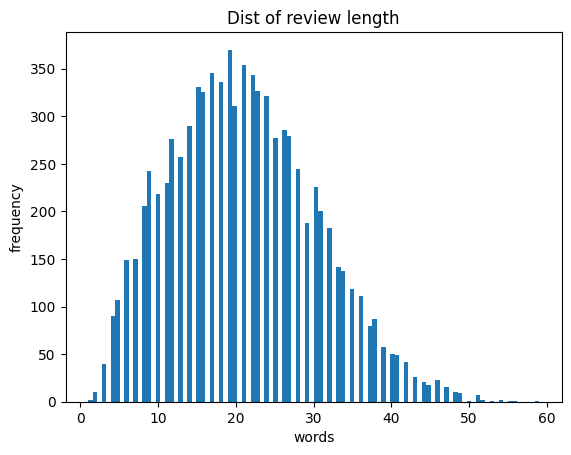

Average length: 20.99284876905041
Median length: 20.0
Max length: 59


In [32]:
# Dataset size (train/test split).

# Labels (positive/negative balance).

# Text length distribution.

# Examples to get a feel for the data.



from collections import Counter


Counter(data["test"]['label'])

import random

# for i in random.sample(range(len(data["train"])), 5):
#   print(data["train"][i])

length = [len(x.split()) for x in data['train']['text']]


import matplotlib.pyplot as plt

plt.hist(length, bins=100)
plt.title("Dist of review length")
plt.xlabel("words")
plt.ylabel("frequency")
plt.show()

import numpy as np

print("Average length:", np.mean(length))
print("Median length:", np.median(length))
print("Max length:", np.max(length))
# Dataset({
#     features: ['text', 'label'],
#     num_rows: 8530
# })Dataset({
#     features: ['text', 'label'],
#     num_rows: 8530
# })

In [ ]:
data["train"][0, -1]

{'text': ['the rock is destined to be the 21st century\'s new " conan " and that he\'s going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .',
  'things really get weird , though not particularly scary : the movie is all portent and no content .'],
 'label': [1, 0]}

# **Text Classification with Representation Models**

## **Using a Task-specific Model**

In [ ]:
from transformers import pipeline

# Path to our HF model
model_path = "cardiffnlp/twitter-roberta-base-sentiment-latest"

# Load model into pipeline
pipe = pipeline(
    model=model_path,
    tokenizer=model_path,
    return_all_scores=True,
    device="cuda:0"
)

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly 

In [ ]:
import numpy as np
from tqdm import tqdm
from transformers.pipelines.pt_utils import KeyDataset

# Run inference
y_pred = []
for output in tqdm(pipe(KeyDataset(data["test"], "text")), total=len(data["test"])):
    negative_score = output[0]["score"]
    positive_score = output[2]["score"]
    assignment = np.argmax([negative_score, positive_score])
    y_pred.append(assignment)

100%|██████████| 1066/1066 [00:37<00:00, 28.25it/s]


In [ ]:
from sklearn.metrics import classification_report

def evaluate_performance(y_true, y_pred):
    """Create and print the classification report"""
    performance = classification_report(
        y_true, y_pred,
        target_names=["Negative Review", "Positive Review"]
    )
    print(performance)

In [ ]:
evaluate_performance(data["test"]["label"], y_pred)

                 precision    recall  f1-score   support

Negative Review       0.76      0.88      0.81       533
Positive Review       0.86      0.72      0.78       533

       accuracy                           0.80      1066
      macro avg       0.81      0.80      0.80      1066
   weighted avg       0.81      0.80      0.80      1066



## **Classification Tasks that Leverage Embeddings**

### Supervised Classification

In [ ]:
from sentence_transformers import SentenceTransformer

# Load model
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

# Convert text to embeddings
train_embeddings = model.encode(data["train"]["text"], show_progress_bar=True)
test_embeddings = model.encode(data["test"]["text"], show_progress_bar=True)

Batches:   0%|          | 0/267 [00:00<?, ?it/s]

Batches:   0%|          | 0/34 [00:00<?, ?it/s]

In [ ]:
train_embeddings.shape

(8530, 768)

In [ ]:
from sklearn.linear_model import LogisticRegression

# Train a Logistic Regression on our train embeddings
clf = LogisticRegression(random_state=42)
clf.fit(train_embeddings, data["train"]["label"])

LogisticRegression(random_state=42)

In [ ]:
# Predict previously unseen instances
y_pred = clf.predict(test_embeddings)
evaluate_performance(data["test"]["label"], y_pred)

                 precision    recall  f1-score   support

Negative Review       0.85      0.86      0.85       533
Positive Review       0.86      0.85      0.85       533

       accuracy                           0.85      1066
      macro avg       0.85      0.85      0.85      1066
   weighted avg       0.85      0.85      0.85      1066



**Tip!**  

What would happen if we would not use a classifier at all? Instead, we can average the embeddings per class and apply cosine similarity to predict which classes match the documents best:

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics.pairwise import cosine_similarity

# Average the embeddings of all documents in each target label
df = pd.DataFrame(np.hstack([train_embeddings, np.array(data["train"]["label"]).reshape(-1, 1)]))
averaged_target_embeddings = df.groupby(768).mean().values

# Find the best matching embeddings between evaluation documents and target embeddings
sim_matrix = cosine_similarity(test_embeddings, averaged_target_embeddings)
y_pred = np.argmax(sim_matrix, axis=1)

# Evaluate the model
evaluate_performance(data["test"]["label"], y_pred)

                 precision    recall  f1-score   support

Negative Review       0.85      0.84      0.84       533
Positive Review       0.84      0.85      0.84       533

       accuracy                           0.84      1066
      macro avg       0.84      0.84      0.84      1066
   weighted avg       0.84      0.84      0.84      1066



### Zero-shot Classification

In [ ]:
# Create embeddings for our labels
label_embeddings = model.encode(["A negative review",  "A positive review"])

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Find the best matching label for each document
sim_matrix = cosine_similarity(test_embeddings, label_embeddings)
y_pred = np.argmax(sim_matrix, axis=1)

In [ ]:
evaluate_performance(data["test"]["label"], y_pred)

                 precision    recall  f1-score   support

Negative Review       0.78      0.77      0.78       533
Positive Review       0.77      0.79      0.78       533

       accuracy                           0.78      1066
      macro avg       0.78      0.78      0.78      1066
   weighted avg       0.78      0.78      0.78      1066



**Tip!**  

What would happen if you were to use different descriptions? Use **"A very negative movie review"** and **"A very positive movie review"** to see what happens!

## **Classification with Generative Models**

### Encoder-decoder Models

In [ ]:
# Load our model
pipe = pipeline(
    "text2text-generation",
    model="google/flan-t5-small",
    device="cuda:0"
)

In [ ]:
# Prepare our data
prompt = "Is the following sentence positive or negative? "
data = data.map(lambda example: {"t5": prompt + example['text']})
data

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 't5'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['text', 'label', 't5'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['text', 'label', 't5'],
        num_rows: 1066
    })
})

In [ ]:
# Run inference
y_pred = []
for output in tqdm(pipe(KeyDataset(data["test"], "t5")), total=len(data["test"])):
    text = output[0]["generated_text"]
    y_pred.append(0 if text == "negative" else 1)


  0%|          | 0/1066 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100%|██████████| 1066/1066 [00:40<00:00, 26.07it/s]


In [ ]:
evaluate_performance(data["test"]["label"], y_pred)

                 precision    recall  f1-score   support

Negative Review       0.83      0.85      0.84       533
Positive Review       0.85      0.83      0.84       533

       accuracy                           0.84      1066
      macro avg       0.84      0.84      0.84      1066
   weighted avg       0.84      0.84      0.84      1066



### ChatGPT for Classification

In [ ]:
import openai

# Create client
client = openai.OpenAI(api_key="YOUR_KEY_HERE")

In [ ]:
def chatgpt_generation(prompt, document, model="gpt-3.5-turbo-0125"):
    """Generate an output based on a prompt and an input document."""
    messages=[
        {
            "role": "system",
            "content": "You are a helpful assistant."
            },
        {
            "role": "user",
            "content":   prompt.replace("[DOCUMENT]", document)
            }
    ]
    chat_completion = client.chat.completions.create(
      messages=messages,
      model=model,
      temperature=0
    )
    return chat_completion.choices[0].message.content

In [ ]:
# Define a prompt template as a base
prompt = """Predict whether the following document is a positive or negative movie review:

[DOCUMENT]

If it is positive return 1 and if it is negative return 0. Do not give any other answers.
"""

# Predict the target using GPT
document = "unpretentious , charming , quirky , original"
chatgpt_generation(prompt, document)

'1'

The next step would be to run one of OpenAI's model against the entire evaluation dataset. However, only run this when you have sufficient tokens as this will call the API for the entire test dataset (1066 records).

In [ ]:
# You can skip this if you want to save your (free) credits
predictions = [chatgpt_generation(prompt, doc) for doc in tqdm(data["test"]["text"])]

100%|██████████| 1066/1066 [13:34<00:00,  1.31it/s]


In [ ]:
# Extract predictions
y_pred = [int(pred) for pred in predictions]

# Evaluate performance
evaluate_performance(data["test"]["label"], y_pred)

                 precision    recall  f1-score   support

Negative Review       0.87      0.97      0.92       533
Positive Review       0.96      0.86      0.91       533

       accuracy                           0.91      1066
      macro avg       0.92      0.91      0.91      1066
   weighted avg       0.92      0.91      0.91      1066

